# Utilizando um outro modelo linear
- Vamos introduzir o conceito de **Regularização**:  
Regularização é uma técnica utilizada em machine learning para prevenir overfitting, que ocorre quando um modelo se ajusta excessivamente aos dados de treinamento, capturando não apenas os padrões relevantes, mas também o ruído e as peculiaridades específicas desses dados. O objetivo da regularização é impor uma penalização para complexidade excessiva do modelo, incentivando-o a ser mais simples e, portanto, mais capaz de generalizar para novos dados.

**Elastic Net**:
   - Combina as penalizações L1 e L2, permitindo um equilíbrio entre a sparsity do Lasso e a suavização do Ridge.

In [1]:
# Importação das bibliotecas necessárias
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    RobustScaler,
    QuantileTransformer
)

from src.config import DADOS_LIMPOS
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)

from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor
)

sns.set_theme(palette='bright')
warnings.filterwarnings("ignore")

In [2]:
# Importando os dados tratados
df = pd.read_parquet(DADOS_LIMPOS)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343676,2.362768,0.203216


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17564 non-null  float32 
 1   latitude                  17564 non-null  float32 
 2   housing_median_age        17564 non-null  int8    
 3   total_rooms               17564 non-null  int16   
 4   total_bedrooms            17564 non-null  int16   
 5   population                17564 non-null  int16   
 6   households                17564 non-null  int16   
 7   median_income             17564 non-null  float32 
 8   median_house_value        17564 non-null  int32   
 9   ocean_proximity           17564 non-null  category
 10  median_income_cat         17564 non-null  int64   
 11  rooms_per_household       17564 non-null  float32 
 12  population_per_household  17564 non-null  float32 
 13  bedrooms_per_room         17564 non-null  floa

In [4]:
# Pegando as colunas que vão sofrer transformações
col_target = ['median_house_value']
col_onehot = ['ocean_proximity']
col_ordinal = ['median_income_cat']

In [5]:
# Separando as colunas que vão ser usadas no RobustScaler
col_robust = df.columns.difference(col_target + col_onehot + col_ordinal)
col_robust

Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population', 'population_per_household',
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object')

In [6]:
# Construindo o Pipeline com o PolynomialFeatures e RobustScaler
pipeline_robust_poly = Pipeline(
    [
        ("robust_scaler", RobustScaler()),
        ("poly", PolynomialFeatures(degree=1, include_bias=False))
    ]
)

preprocessamento = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(drop='first'), col_onehot),
        ('ordinal_encoder', OrdinalEncoder(categories='auto'), col_ordinal),
        ('robust_and_poly', pipeline_robust_poly, col_robust),
    ],
)

In [7]:
# Separando em X e y
X = df.drop(columns=col_target)
y = df[col_target]

In [8]:
# Grade de parâmetros dos transformadores
param_grid = {
    "regressor__preprocessor__robust_and_poly__poly__degree": [1, 2, 3],
    "regressor__reg__alpha":[1E-2, 5E-2, 0.1, 0.25, 0.5, 1.0],
    "regressor__reg__l1_ratio":[0.1, 0.25, 0.5, 0.75, 0.9],
}

# Função que constrói Pipeline com preprocessamento e regressor e executa o GridSearchCV
grid_search = grid_search_cv_regressor(
    regressor=ElasticNet(),
    preprocessor=preprocessamento,
    target_transformer=QuantileTransformer(output_distribution='normal'),
    param_grid=param_grid
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('robust_and_poly',
                                                                                                              Pipeline(steps=[('robust_scaler',
                                                                                                                               Robus...
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_and_poly__poly__degree': [1,
                                                                                    2,
                                                                                    3],
                         'regressor__reg__alpha': [0.01, 0.05, 0.1, 0.25, 0.5,
                                                   1.0],
                         'regressor__reg__l1_ratio': [0.1, 0.25, 0.5, 0.75,
                                                      0.9]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [9]:
# Submetendo os dados ao modelo
grid_search.fit(X, y)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('robust_and_poly',
                                                                                                              Pipeline(steps=[('robust_scaler',
                                                                                                                               Robus...
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_and_poly__poly__degree': [1,
                                                                                    2,
                                                                                    3],
                         'regressor__reg__alpha': [0.01, 0.05, 0.1, 0.25, 0.5,
                                                   1.0],
                         'regressor__reg__l1_ratio': [0.1, 0.25, 0.5, 0.75,
                                                      0.9]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

- **Alpha**: Controla a intensidade geral da regularização.
- **L1_ratio**: Define o equilíbrio entre L1 (esparsidade) e L2 (suavização).

In [10]:
# O melhor parâmetro
grid_search.best_params_

{'regressor__preprocessor__robust_and_poly__poly__degree': 3,
 'regressor__reg__alpha': 0.01,
 'regressor__reg__l1_ratio': 0.1}

O modelo tende a uma penalização um pouco mais suave, por isso o *alpha* baixo, e ele também tende a penalização puramente Ridge.

In [11]:
# A melhor pontuação
grid_search.best_score_

np.float64(-51306.41969521367)

Ouve uma pequena variação na métrica.

In [12]:
# Criando um DF com as colunas e seus respectivos coeficientes
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_['reg'].coef_,
    grid_search.best_estimator_.regressor_['preprocessor'].get_feature_names_out()
)

coefs

,coeficiente
one_hot__ocean_proximity_INLAND,-0.607826
robust_and_poly__longitude,-0.385711
robust_and_poly__population_per_household,-0.345935
robust_and_poly__latitude,-0.215080
robust_and_poly__latitude^2,-0.196782
...,...
ordinal_encoder__median_income_cat,0.093232
robust_and_poly__housing_median_age longitude^2,0.109394
robust_and_poly__bedrooms_per_room,0.131100
robust_and_poly__housing_median_age median_income,0.182319


In [13]:
# Verificando se há coeficientes nulos
coefs[coefs['coeficiente'] == 0]

,coeficiente
robust_and_poly__bedrooms_per_room population_per_household,-0.0
robust_and_poly__population_per_household total_rooms^2,0.0
robust_and_poly__total_rooms^3,0.0
robust_and_poly__total_rooms,0.0
robust_and_poly__total_bedrooms total_rooms^2,0.0
...,...
robust_and_poly__median_income population_per_household total_rooms,-0.0
robust_and_poly__longitude rooms_per_household total_rooms,0.0
robust_and_poly__longitude population population_per_household,-0.0
robust_and_poly__longitude population^2,-0.0


Muitos coeficientes zerados devido a Penalização.

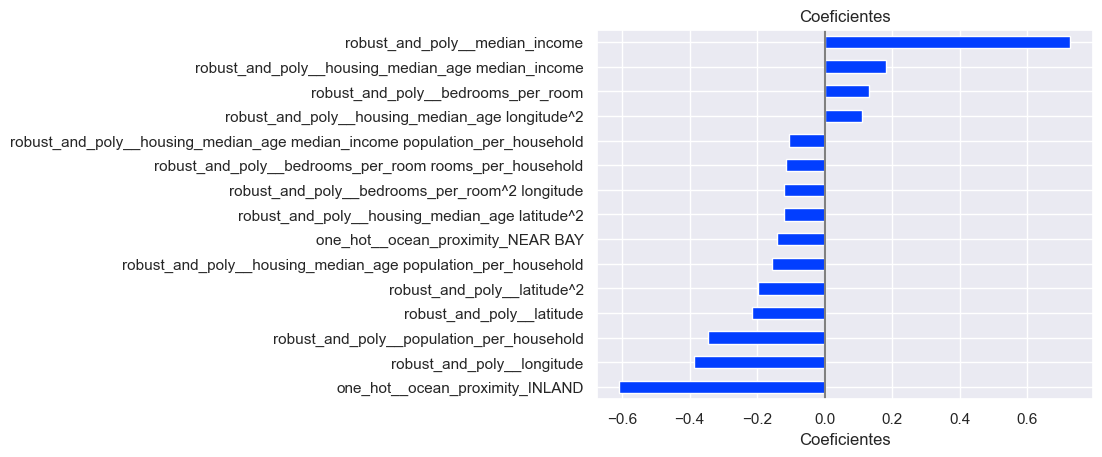

In [14]:
# Selecionando os mais relevantes
plot_coeficientes(coefs[~coefs['coeficiente'].between(-0.1, 0.1)])

In [15]:
# Recriando o dicionário de regressores para a nova análise
regressors = {
    'DummyRegressor': {
        'preprocessor': None,
        'regressor': DummyRegressor(strategy='mean'),
        'target_transformer': None,
    },
    'LinearRegression': {
        'preprocessor': preprocessamento,
        'regressor': LinearRegression(),
        'target_transformer': None,
    },
    'LinearRegression_target': {
        'preprocessor': preprocessamento,
        'regressor': LinearRegression(),
        'target_transformer': QuantileTransformer(output_distribution='normal'),
    },
    'ElasticNet_grid_search': {
        'preprocessor': grid_search.best_estimator_.regressor_['preprocessor'],
        'regressor': grid_search.best_estimator_.regressor_['reg'],
        'target_transformer': grid_search.best_estimator_.transformer_,
    },
}

In [16]:
# Treinando e validando os modelos do dicionário de regressores. Transformando os resultados em um DF.
resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **modelo_etapas)
    for nome_modelo, modelo_etapas in regressors.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.0,0.015944,-0.000081,-77516.042766,-96239.705692,0.015944
1,DummyRegressor,0.0,0.020823,-0.000146,-75787.787194,-95217.629397,0.020823
2,DummyRegressor,0.006997,0.008145,-0.001737,-76753.598961,-96253.253947,0.015141
3,DummyRegressor,0.005997,0.003006,-0.000101,-76837.804811,-95983.885799,0.009002
4,DummyRegressor,0.010313,0.005593,-0.000114,-76617.245449,-96182.764729,0.015906
5,LinearRegression,0.070452,0.015798,0.682162,-39855.690996,-54254.958188,0.08625
6,LinearRegression,0.071813,0.015728,0.66999,-40272.565467,-54695.230283,0.087541
7,LinearRegression,0.068192,0.031812,0.649247,-42178.05929,-56955.988706,0.100004
8,LinearRegression,0.063555,0.031695,0.669873,-40806.492497,-55146.318803,0.095249
9,LinearRegression,0.063338,0.01584,0.669023,-40788.496497,-55331.35106,0.079178


In [17]:
df_resultados.groupby('model').mean().sort_values(by='time_seconds')

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.004661,0.010702,-0.000436,-76702.495836,-95975.447913,0.015363
LinearRegression,0.06747,0.022175,0.668059,-40780.26095,-55276.769408,0.089645
LinearRegression_target,0.088117,0.019962,0.678147,-38677.701632,-54426.32407,0.108078
ElasticNet_grid_search,81.085206,0.039852,0.714001,-36001.23822,-51298.273779,81.125058


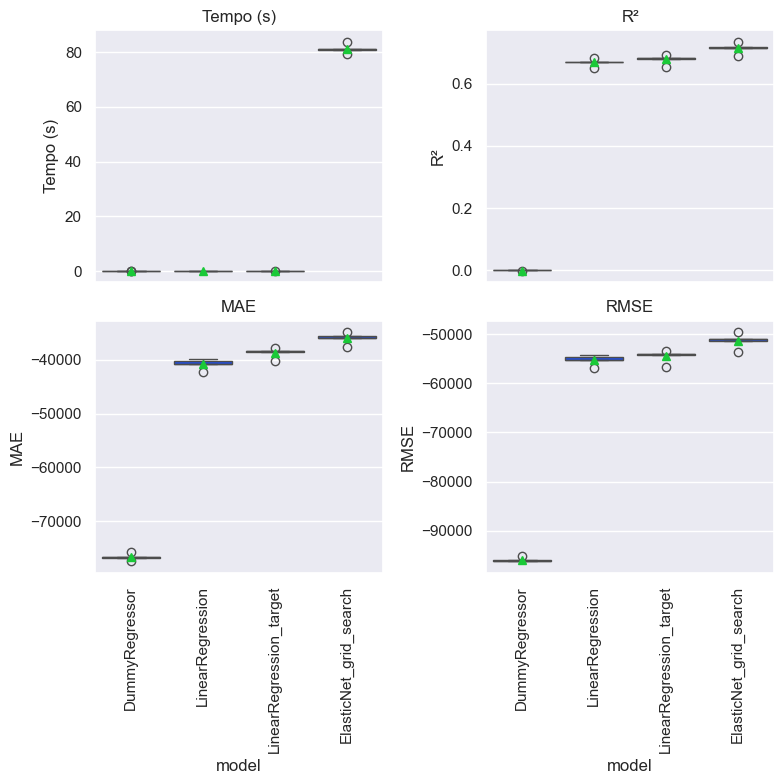

In [18]:
plot_comparar_metricas_modelos(df_resultados)

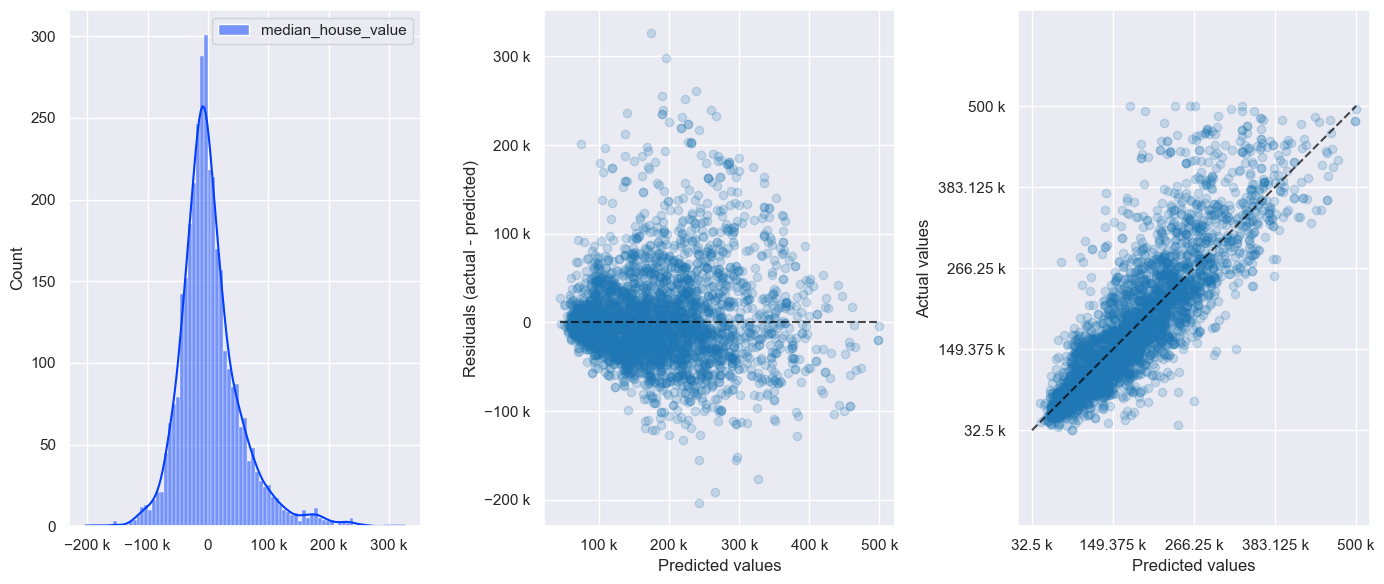

In [19]:
plot_residuos_estimador(grid_search.best_estimator_, X, y, fracao_amostra=0.2, eng_formatter=True)

### Conclusão:
- Não obtivemos mudanças significativas nas métricas de interesse, porém ganhamos no quesito interpretação dos resultados, caso fosse necessário explicar o resultados dos coeficientes com o modelo atual seria mais fácil em comparação com o anterior, onde tinhamos vários polinomios que não pareciam fazer muito sentido.
- Vemos também que o ElasticNet tende a regulazação Ridge, e por isso iremos adotar essa abordagem na proxima etapa; principalmente pelo fato de que o ElasticNet demorou demais para executar, e o Ridge tende mesmo a ser mais rápido.